In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import numpy.random as rand
import scipy.fftpack as fft
import matplotlib.pyplot as mp
import matplotlib.animation as anim
import matplotlib.patches as patch
import scipy.fftpack as fft
import keras
import keras.backend as K
import keras.preprocessing as kpre
import keras.datasets as kdat
import keras.models as kmod
import keras.layers as klay
import keras.optimizers as kopt
import keras.utils as kutil
import keras.callbacks as kcbck
import keras.initializers as kinit
import keras.regularizers as kreg
import keras.applications as kapp
import keras.engine as keng
import sklearn.model_selection as slms
import sklearn.utils as slutil
import sklearn.cluster as slcl
import sklearn.metrics as slmet
import skvideo.io as svio
import skimage.transform as sitr
import tensorflow as tf
import pandas as pd
import cv2 as cv
import bs4, requests, re
import urllib as url
from tqdm import tnrange, tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback as ktqdm
from ann_visualizer.visualize import ann_viz
from jupyterthemes import jtplot

Using TensorFlow backend.


In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (5*16/9, 5)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
cwd = 'd:/kenneth/documents/vip/datasets/cat-and-dog/'
traindir = cwd + 'TRAIN/'
testdir = cwd + 'TEST/'

# Prepare training data

In [4]:
img_w = 124
img_h = 124
img_size = (img_w, img_h)
img_ch = 3
batch_size = 512

In [18]:
filenames = os.listdir(traindir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
train_df = pd.DataFrame({'filename': filenames,
                         'category': categories})

In [19]:
train_df, val_df = slms.train_test_split(train_df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [20]:
train_datagen = kpre.image.ImageDataGenerator(rescale=1/255,
                                              shear_range=0.2,
                                              zoom_range=0.2,
                                              horizontal_flip=True)
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              traindir,
                                              x_col='filename',
                                              y_col='category',
                                              target_size=img_size,
                                              batch_size=batch_size,
#                                               color_mode='grayscale',
                                              class_mode='input')

Found 6404 images.


In [21]:
val_gen = train_datagen.flow_from_dataframe(val_df,
                                            traindir,
                                            x_col='filename',
                                            y_col='category',
                                            target_size=img_size,
                                            batch_size=batch_size,
#                                             color_mode='grayscale',
                                            class_mode='input')

Found 1601 images.


In [22]:
total_train = train_df.shape[0]
total_val = val_df.shape[0]

In [5]:
def noisy_generator(batches, comp_ratio=0.5):
    for xbatch, ybatch in batches:
        ybatch = xbatch.copy()
        xbatch = xbatch * rand.choice([0, 1], size=xbatch.shape, p=[1-comp_ratio, comp_ratio])
        yield (xbatch, ybatch)

# Initialize network

In [6]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

In [9]:
input_img = klay.Input(shape=(img_w, img_h, img_ch),
                       name='input')


enc = klay.Conv2D(filters=16,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same',
                  strides=2,
                  name='enc_conv1')(input_img)
enc = klay.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same',
                  strides=2,
                  name='enc_conv2')(enc)
enc = klay.Conv2D(filters=32,
                  kernel_size=(2, 2),
                  activation='relu',
                  padding='same',
                  strides=2,
                  name='enc_conv3')(enc)

# original vector is 124*124*3 = 46,128
# compressed vector is 16*16*32 = 8192
# compression ratio is 17.76%

dec = klay.Conv2D(filters=32,
                  kernel_size=(2, 2),
                  activation='relu',
                  padding='same',
                  name='dec_conv1')(enc)
dec = klay.UpSampling2D(size=(2, 2),
                        name='dec_upsamp1')(dec)
dec = klay.Conv2D(filters=32,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same',
                  name='dec_conv2')(dec)
dec = klay.UpSampling2D(size=(2, 2),
                        name='dec_upsamp2')(dec)
dec = klay.Conv2D(filters=16,
                  kernel_size=(3, 3),
                  activation='relu',
                  name='dec_conv3')(dec)
dec = klay.UpSampling2D(size=(2, 2),
                        name='dec_upsamp3')(dec)
dec = klay.Conv2D(filters=3,
                  kernel_size=(3, 3),
                  activation='sigmoid',
                  padding='same',
                  name='dec_activation')(dec)


autoenc = kmod.Model(input_img, dec)
autoenc.compile(optimizer='adam',
                loss='mse',
                metrics=[psnr, ssim])
autoenc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 124, 124, 3)       0         
_________________________________________________________________
enc_conv1 (Conv2D)           (None, 62, 62, 16)        448       
_________________________________________________________________
enc_conv2 (Conv2D)           (None, 31, 31, 32)        4640      
_________________________________________________________________
enc_conv3 (Conv2D)           (None, 16, 16, 32)        4128      
_________________________________________________________________
dec_conv1 (Conv2D)           (None, 16, 16, 32)        4128      
_________________________________________________________________
dec_upsamp1 (UpSampling2D)   (None, 32, 32, 32)        0         
_________________________________________________________________
dec_conv2 (Conv2D)           (None, 32, 32, 32)        9248      
__________

In [7]:
epochs = 10
checkpoint = kcbck.ModelCheckpoint('autoenc_best_weights.h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')
history = kcbck.History()
lr_reduce = kcbck.ReduceLROnPlateau(monitor='val_loss',
                                    patience=2,
                                    verbose=0,
                                    factor=0.5,
                                    min_lr=0.00001)
# autoenc.load_weights('autoenc_best_weights.h5')

In [ ]:
autoenc.fit_generator(noisy_generator(train_gen, 0.5),
                      epochs=epochs,
                      validation_data=noisy_generator(val_gen, 0.5),
                      validation_steps=total_val//batch_size,
                      steps_per_epoch=total_train//batch_size,
                      verbose=0,
                      callbacks=[ktqdm(), history, checkpoint, lr_reduce])
autoenc.save('autoenc.model')

In [8]:
autoenc = kmod.load_model('autoenc.model', custom_objects={'psnr': psnr,
                                                           'ssim': ssim})
autoenc.load_weights('autoenc_best_weights.h5')

W0822 22:23:56.658989 13328 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 22:23:56.724009 13328 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.

W0822 22:23:57.129374 13328 module_wrapper.py:136] From D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\tensorflow_core\python\util\module_wrapper.py:163: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



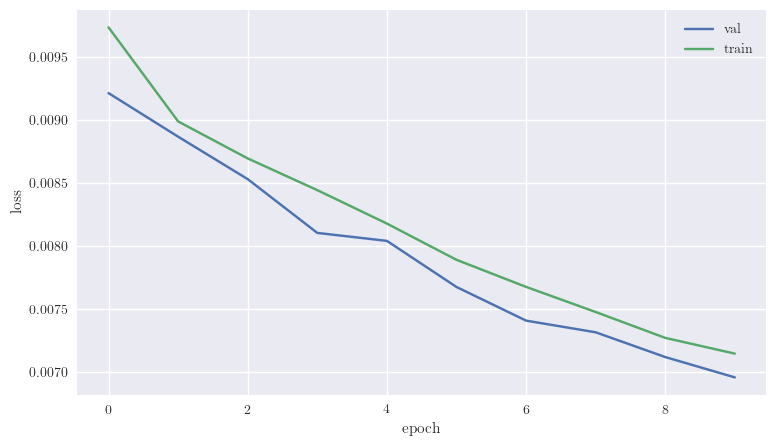

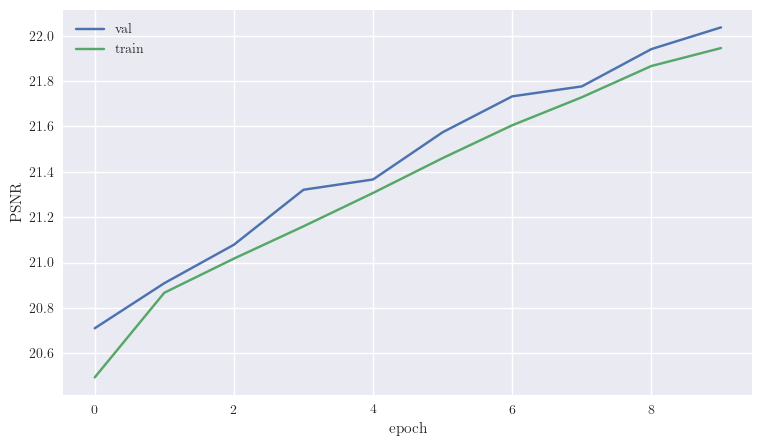

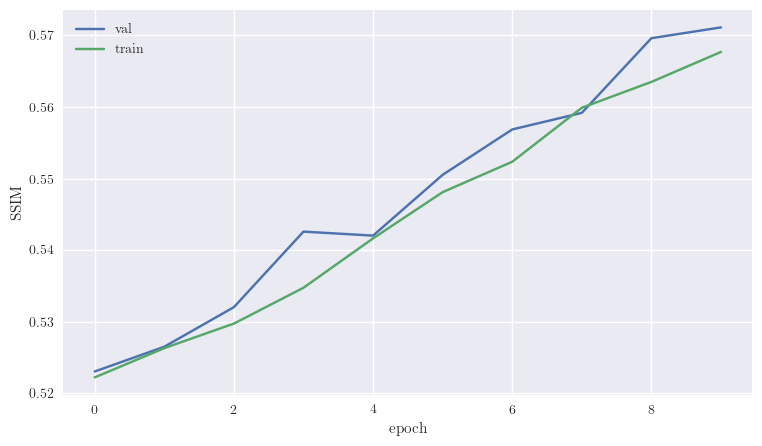

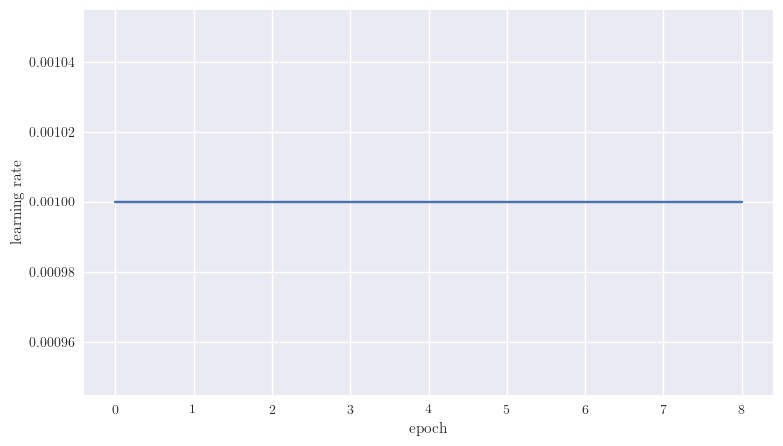

In [164]:
mp.figure()
mp.plot(history.epoch, history.history['val_loss'],
        history.epoch, history.history['loss'])
mp.xlabel('epoch')
mp.ylabel('loss')
mp.legend(['val', 'train'])
# mp.savefig('190810-autoenc-loss-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()


mp.figure()
mp.plot(history.epoch, history.history['val_psnr'],
        history.epoch, history.history['psnr'])
mp.xlabel('epoch')
mp.ylabel('PSNR')
mp.legend(['val', 'train'])
# mp.savefig('190810-autoenc-psnr-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

mp.figure()
mp.plot(history.epoch, history.history['val_ssim'],
        history.epoch, history.history['ssim'])
mp.xlabel('epoch')
mp.ylabel('SSIM')
mp.legend(['val', 'train'])
# mp.savefig('190810-autoenc-ssim-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

mp.figure()
mp.plot(history.epoch[:-1], history.history['lr'])
mp.xlabel('epoch')
mp.ylabel('learning rate')
# mp.savefig('190810-autoenc-lr-50.png', 
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()

# Prepare test data

In [9]:
filenames = os.listdir(testdir)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
test_df = pd.DataFrame({'filename': filenames,
                         'category': categories})

In [10]:
test_datagen = kpre.image.ImageDataGenerator(rescale=1/255)
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            testdir,
                                            x_col='filename',
                                            y_col=None,
                                            target_size=img_size,
                                            batch_size=batch_size,
#                                             color_mode='grayscale',
                                            class_mode='input')

Found 2023 images.


In [11]:
x_test = next(noisy_generator(test_gen, 0.9))

In [12]:
dec_img = autoenc.predict(x_test[0])

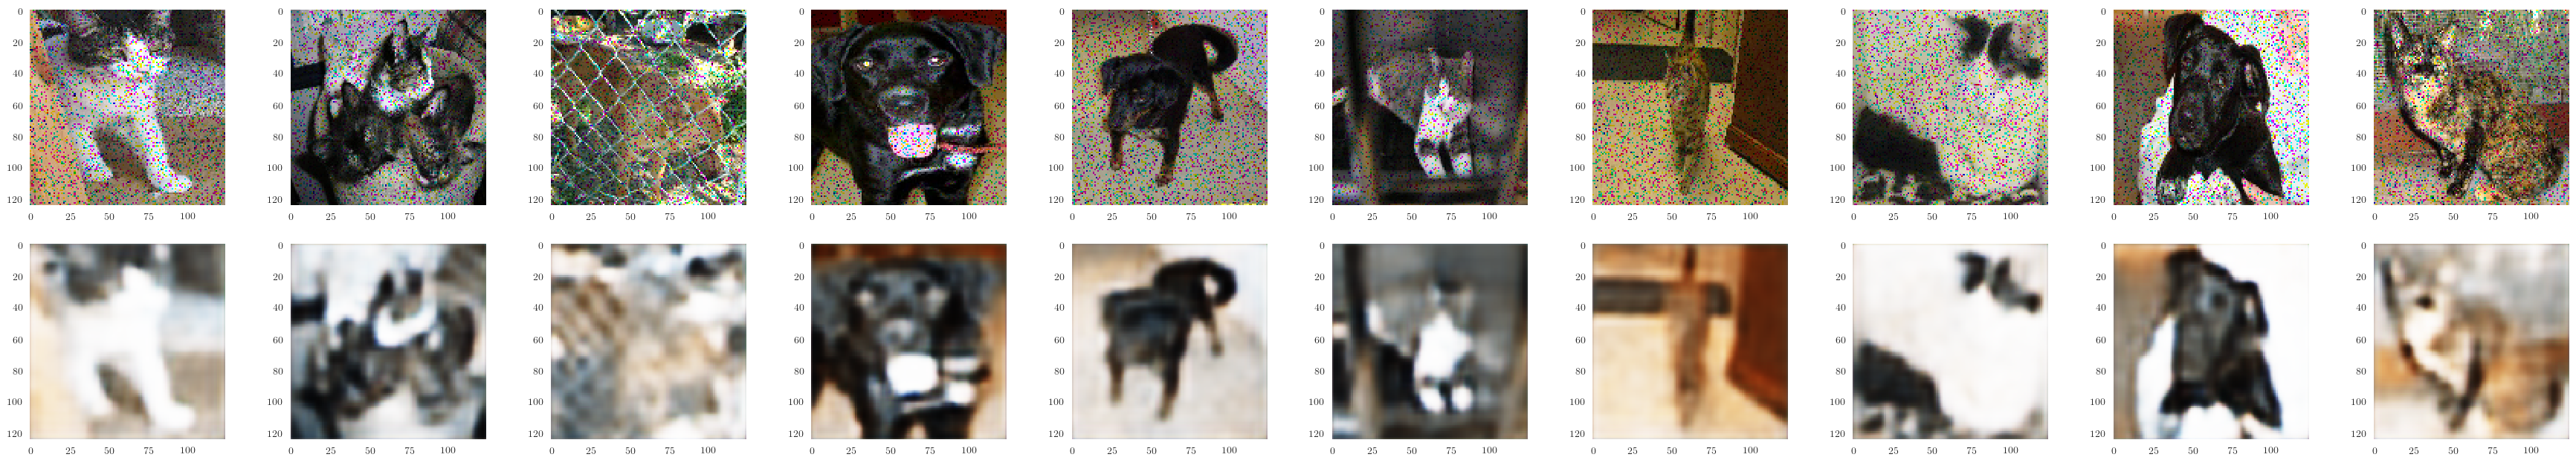

In [13]:
fig = mp.figure(figsize=(5*16/9*5, 5*1.5))
for i in range(10):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(x_test[0][i], 'gray')
    ax.grid(False)
    
    ax = fig.add_subplot(2, 10, 10+i+1)
    ax.imshow(dec_img[i], 'gray')
    ax.grid(False)

# mp.savefig('190810-autoenc-recov-50cent.png',
#            dpi=300, 
#            bbox_inches='tight', 
#            transparent=True)
mp.show()